In [8]:
dataset="dataset"

In [4]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from sklearn.utils import shuffle
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
tf.get_logger().setLevel("ERROR")
from PIL import Image,ImageFilter


In [9]:
x_train = []
y_train = []
image_size = 224
labels =  [ 'ક','ખ', 'ગ','ઘ', 'ચ', 'છ', 'જ', 'ટ', 'ઠ', 'ડ', 'ઢ', 'ણ', 'ત', 'થ', 'દ', 'ધ', 'ન',
     'ફ', 'બ', 'ભ', 'મ', 'ય', 'ર', 'લ', 'વ','શ','ષ' , 'સ' ,'હ','ળ','ક્ષ', 'જ્ઞ','0']

for _ in range(2):
    for i in labels:
        folderPath = os.path.join(dataset,i)
        for j in os.listdir(folderPath):
            img = Image.open(os.path.join(folderPath,j))
            # img = np.array(img)
            img = img.resize((image_size,image_size))
            img = img.convert('L')
            img= img.filter(ImageFilter.FIND_EDGES)
            img = img.point(lambda x : 255 if x >45 else 0)
            img = np.array(img)
            # print(img)
            x_train.append(img)
            y_train.append(i)
        print(f"Loaded {i} images")    
# for i in labels:
#     folderPath = os.path.join(dataset,i)
#     for j in os.listdir(folderPath):
#         img = Image.open(os.path.join(folderPath,j))
#         img = np.array(img)
#         img = img.resize((image_size,image_size))
#         img.convert('L')
        
#         x_train.append(img)
#         y_train.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)

Loaded ક images
Loaded ખ images
Loaded ગ images
Loaded ઘ images
Loaded ચ images
Loaded છ images
Loaded જ images
Loaded ટ images
Loaded ઠ images
Loaded ડ images
Loaded ઢ images
Loaded ણ images
Loaded ત images
Loaded થ images
Loaded દ images
Loaded ધ images
Loaded ન images
Loaded ફ images
Loaded બ images
Loaded ભ images
Loaded મ images
Loaded ય images
Loaded ર images
Loaded લ images
Loaded વ images
Loaded શ images
Loaded ષ images
Loaded સ images
Loaded હ images
Loaded ળ images
Loaded ક્ષ images
Loaded જ્ઞ images
Loaded 0 images
Loaded ક images
Loaded ખ images
Loaded ગ images
Loaded ઘ images
Loaded ચ images
Loaded છ images
Loaded જ images
Loaded ટ images
Loaded ઠ images
Loaded ડ images
Loaded ઢ images
Loaded ણ images
Loaded ત images
Loaded થ images
Loaded દ images
Loaded ધ images
Loaded ન images
Loaded ફ images
Loaded બ images
Loaded ભ images
Loaded મ images
Loaded ય images
Loaded ર images
Loaded લ images
Loaded વ images
Loaded શ images
Loaded ષ images
Loaded સ images
Loaded હ images
Load

In [4]:
# np.unique(x_train)

In [5]:
print(len(labels))

33


In [10]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_train.shape

(6482, 224, 224)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

C:\Users\dsmat\AppData\Local\Temp\ipykernel_1452\2496448203.py:15: UserWarning: 
The palette list has fewer values (4) than needed (33) and will cycle, which may produce an uninterpretable plot.
  bar_plot = sns.barplot(x='Group', y='Number of Image', hue='Sign Type', data=df, palette=['#7ED321', '#D0021B', '#4A90E2', '#F5A623'])
C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2724 (\N{GUJARATI LETTER TA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Gujarati natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2727 (\N{GUJARATI LETTER DHA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dsmat\AppData\Roaming\Pyth

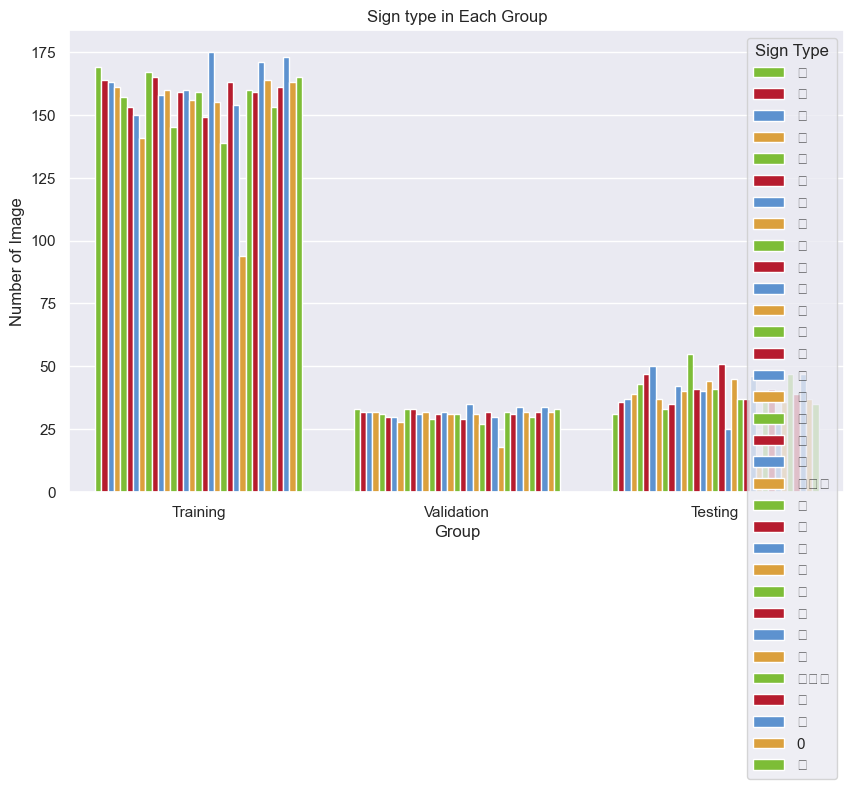

In [8]:
from collections import Counter
train_counts = Counter(Y_train)
val_counts = Counter(Y_train)  
test_counts = Counter(Y_test)
data = {
    'Group': ['Training']*len(train_counts) + ['Validation']*len(train_counts) + ['Testing']*len(test_counts),
    'Sign Type': list(train_counts.keys()) + list(train_counts.keys()) + list(test_counts.keys()),
    'Number of Image': list(train_counts.values()) + [int(v * 0.2) for v in train_counts.values()] + list(test_counts.values())
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")

bar_plot = sns.barplot(x='Group', y='Number of Image', hue='Sign Type', data=df, palette=['#7ED321', '#D0021B', '#4A90E2', '#F5A623'])
plt.title('Sign type in Each Group')
plt.xlabel('Group')
plt.ylabel('Number of Image')
plt.show()

In [9]:
print("train shape", X_train.shape, Y_train.shape)
print("test shape", X_test.shape, Y_test.shape)

train shape (5185, 224, 224) (5185,)
test shape (1297, 224, 224) (1297,)


In [10]:
print(Y_train[:5])
print(Y_test[:5])

['ત' 'ત' 'ધ' 'હ' 'ધ']
['હ' 'ય' 'છ' 'દ' 'લ']


In [12]:
gujarati_ascii_dict = {char: i for i,  char in enumerate(labels)}
for char, ascii_value in gujarati_ascii_dict.items():
    print(f"{char}: {ascii_value}")

ક: 0
ખ: 1
ગ: 2
ઘ: 3
ચ: 4
છ: 5
જ: 6
ટ: 7
ઠ: 8
ડ: 9
ઢ: 10
ણ: 11
ત: 12
થ: 13
દ: 14
ધ: 15
ન: 16
ફ: 17
બ: 18
ભ: 19
મ: 20
ય: 21
ર: 22
લ: 23
વ: 24
શ: 25
ષ: 26
સ: 27
હ: 28
ળ: 29
ક્ષ: 30
જ્ઞ: 31
0: 32


In [14]:
Y_train_list = []
for i in Y_train:
        # If i is a lowercase letter, map it to a unique integer
        Y_train_list.append(gujarati_ascii_dict[i])

# Convert to categorical
y_train1 = tf.keras.utils.to_categorical(Y_train_list , num_classes=len(labels))


In [15]:
print("one hot encoding \n", y_train1[:5])

one hot encoding 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
Y_test_list = []
for i in Y_test:
    if i.isdigit():
        Y_test_list.append(int(i))
    else:
        # If i is a lowercase letter, map it to a unique integer
        Y_test_list.append(gujarati_ascii_dict[i])

# Convert to categorical
print(Y_test_list)
y_test1 = tf.keras.utils.to_categorical(Y_test_list, num_classes=len(labels))


[28, 21, 5, 14, 23, 19, 21, 0, 25, 8, 13, 8, 15, 20, 27, 25, 25, 29, 30, 21, 8, 8, 8, 25, 10, 28, 24, 22, 31, 7, 13, 5, 15, 19, 31, 31, 9, 10, 11, 26, 3, 27, 13, 0, 20, 30, 7, 29, 17, 11, 1, 21, 23, 11, 10, 31, 4, 23, 0, 30, 6, 11, 7, 12, 2, 16, 8, 1, 10, 30, 21, 16, 0, 27, 10, 14, 5, 5, 5, 31, 0, 5, 28, 0, 1, 30, 31, 23, 10, 19, 9, 15, 31, 14, 3, 18, 22, 7, 6, 21, 20, 5, 26, 17, 15, 17, 28, 20, 17, 23, 14, 16, 2, 3, 16, 6, 14, 22, 11, 22, 17, 29, 13, 28, 20, 8, 20, 30, 30, 20, 3, 1, 28, 0, 9, 7, 7, 7, 26, 13, 11, 17, 0, 21, 21, 8, 28, 21, 15, 8, 12, 8, 9, 19, 19, 27, 0, 9, 2, 3, 21, 10, 21, 3, 12, 23, 24, 16, 14, 15, 30, 19, 8, 25, 22, 7, 7, 21, 25, 25, 22, 0, 21, 0, 27, 26, 2, 6, 5, 18, 24, 28, 11, 16, 14, 5, 16, 3, 19, 14, 16, 13, 20, 22, 21, 31, 18, 17, 16, 2, 26, 14, 22, 30, 31, 9, 19, 13, 29, 16, 17, 19, 10, 11, 19, 1, 4, 13, 25, 9, 20, 1, 27, 31, 12, 7, 20, 30, 10, 28, 23, 25, 10, 7, 29, 20, 15, 13, 8, 30, 24, 30, 23, 29, 8, 12, 26, 13, 0, 25, 19, 11, 11, 19, 16, 29, 0, 1, 8, 21

In [16]:
y_test1[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [18]:
input_layer = Input(shape=(224, 224, 1))

# Load VGG19 without pretrained weights
base_model = VGG19(weights=None, include_top=False, input_tensor=input_layer)

# Add custom layers
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(len(labels), activation='softmax', name='predictions')(x)

model = Model(inputs=input_layer, outputs=x)

In [17]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Define the file path
file_path = os.path.join(current_dir, 'vgg19_model_o8.keras')

checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

callbacks = [checkpoint, reduce_learning_rate, early_stopping]


In [18]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=["accuracy", "precision", "recall", "auc"])

In [ ]:
history = model.fit(X_train, y_train1, epochs=100, batch_size=32, validation_split=0.2, callbacks = callbacks)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3629 - auc: 0.8192 - loss: 2.3905 - precision: 0.6801 - recall: 0.2123 
Epoch 1: val_loss improved from inf to 0.50187, saving model to d:\SRP\totnew\vgg19_model_o8.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 1715s 13s/step - accuracy: 0.3647 - auc: 0.8201 - loss: 2.3838 - precision: 0.6815 - recall: 0.2142 - val_accuracy: 0.8554 - val_auc: 0.9898 - val_loss: 0.5019 - val_precision: 0.9015 - val_recall: 0.8033 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9031 - auc: 0.9949 - loss: 0.3442 - precision: 0.9276 - recall: 0.8746 
Epoch 2: val_loss improved from 0.50187 to 0.24215, saving model to d:\SRP\totnew\vgg19_model_o8.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 1609s 12s/step - accuracy: 0.9032 - auc: 0.9949 - loss: 0.3440 - precision: 0.9277 - recall: 0.8747 - val_accuracy: 0.9335 - val_auc: 0.9986 - val_loss: 0.2422 - val_precision: 0.9476 - val_recall: 0.9065 - learning_rate: 1.0000e

In [2]:
model.save("model_on_Edge_GrayScale_WithoutImgnet.h5") 


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [6]:

model = tf.keras.models.load_model("model_on_Edge_GrayScale_WithoutImgnet.h5")


In [17]:
predic = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step


In [18]:
y_pred = np.argmax(predic, axis=1)
y_pred = np.ravel(y_pred)
print(y_pred)


[28 21  5 ... 30 17 27]


In [19]:
y_test2 = np.argmax(y_test1, axis=1)
y_test2 = np.ravel(y_test2)

array([[39,  0,  0, ...,  0,  0, 37],
       [ 0, 33,  0, ...,  0,  0,  0],
       [ 0,  0, 37, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 47,  0,  0],
       [ 0,  0,  0, ...,  0, 45,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

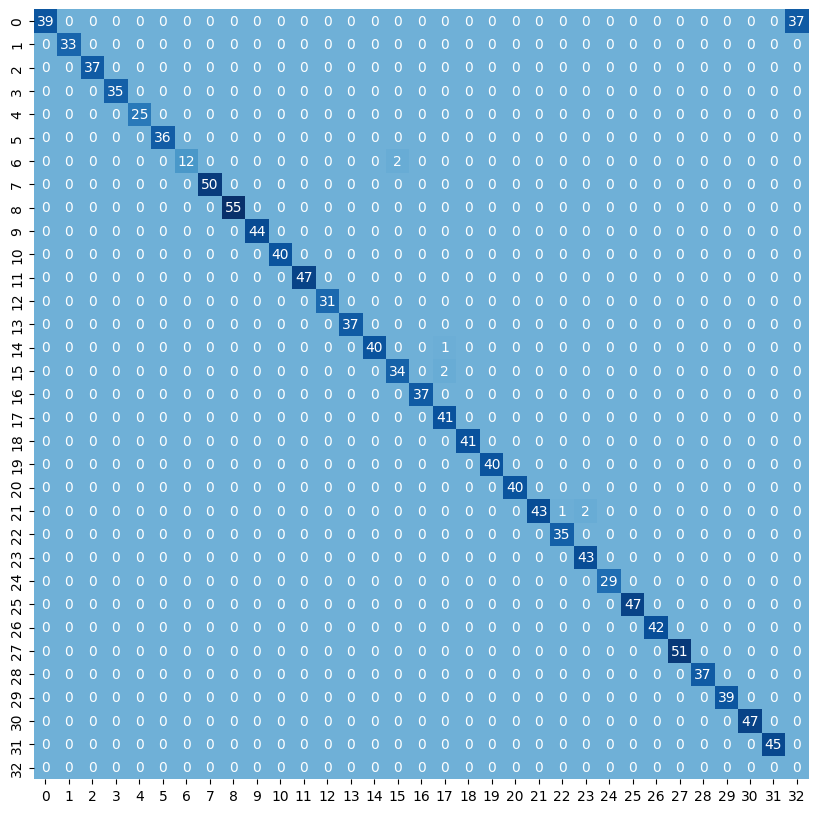

In [20]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
CM = confusion_matrix(y_test2,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision = precision_score(y_test2, y_pred, average='macro')
recall = recall_score(y_test2, y_pred, average='macro')
f1 = f1_score(y_test2, y_pred, average='macro')
accuracy = accuracy_score(y_test2, y_pred)

C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
precision, recall, f1, accuracy

(0.9637588001224364, 0.946216289730829, 0.9523522059239126, 0.9653045489591364)

In [1]:
import tensorflow as tf 
model2 = tf.keras.models.load_model("model_on_Edge_GrayScale_WithoutImgnet.h5") 

In [2]:
model2 = tf.keras.models.load_model("model_on_Edge_RGB.h5", compile=False)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 139,705,441 (532.93 MB)

 Trainable params: 119,681,057 (456.55 MB)

 Non-trainable params: 20,024,384 (76.39 MB)